# 🖌️ View as RGB images


In [ ]:
#| default_exp repr_rgb

In [ ]:
# |hide
from nbdev.showdoc import *
from fastcore.test import test_eq
from lovely_numpy import lo

In [ ]:
# |export
# |hide
from typing import Any, Optional as O

import numpy as np
from matplotlib import pyplot as plt, axes, figure
from lovely_numpy.utils.tile2d import hypertile
from lovely_numpy.utils.utils import cached_property
from lovely_numpy.utils import get_config

In [ ]:
# |hide
import matplotlib

In [ ]:
# |hide
# For output consistency (less diff)
np.random.seed(1)
matplotlib.rcParams["svg.hashsalt"] = "1"
%config InlineBackend.print_figure_kwargs = {'metadata': {"Date": None, "Software": "Matplotlib, https://matplotlib.org/" }}

In [ ]:
# |exporti
IMAGENET_MEANS = np.array((0.485, 0.456, 0.406))
IMAGENET_STDS = np.array((0.229, 0.224, 0.225))

def fig_rgb(x           :np.ndarray,        # Array to display. [[...], C,H,W] or [[...], H,W,C]
            denorm      :Any    =None,      # Reverse per-channel normalization
            cl          :Any    =True,      # Channel-last format
            gutter_px   :int    =3,         # If more than one tensor -> tile with this gutter width
            frame_px    :int    =1,         # If more than one tensor -> tile with this frame width
            scale       :int    =1,         # Stretch the image. Only integers please.
            view_width  :int    =966,       # target width of the image
            clip        :bool   =True,      # Silently clip RGB values to [0, 1] for float, and [0, 255] for uint
            ax          :O[axes.Axes]=None  # Matplotlib axes
        ) -> figure.Figure:

    assert x.ndim >= 3, f"Expecting 3 or more dimension input, got shape=({x.shape})"
    assert x.size > 0, f"Expecting non-empty input, got shape=({x.shape})"
    # swap channels if it's not channel-last already
    if not cl:
        x = np.swapaxes(np.swapaxes(x, -3, -1), -3, -2)

    scale = int(scale)
    x = x.repeat(scale, axis=-2).repeat(scale, axis=-3)

    n_ch = x.shape[-1]
    assert n_ch in (3, 4), f"Expecting 3 (RGB) or 4 (RGBA) color channels, got {n_ch}, shape=({x.shape})"
    if denorm:
        if isinstance(denorm, str):
            denorm_lower = denorm.lower()
            if denorm_lower == 'imagenet':
                x = x * IMAGENET_STDS + IMAGENET_MEANS
            elif denorm_lower == 'symmetric':  # For data that was symmetrically normalized to [-1, 1]
                x = x * 0.5 + 0.5
            elif denorm_lower == 'minmax':  # Maps the actual data range to [0, 1] with use of a small eps (1e-8) for avoiding division by zero
                eps = 1e-8
                finite = np.isfinite(x)
                if np.any(finite):
                    x_valid = np.where(finite, x, np.nan)
                    reduce_axes = tuple(range(x.ndim - 1))
                    x_min = np.nanmin(x_valid, axis=reduce_axes, keepdims=True)
                    x_max = np.nanmax(x_valid, axis=reduce_axes, keepdims=True)
                    x = 0.5 + (x - 0.5 * (x_max + x_min)) / ((x_max - x_min) + eps)
            else:
                raise AssertionError(f"Unsupported denormalization string specification: {denorm}")
        else:
            means = np.array(denorm[0])
            stds = np.array(denorm[1])
            x = x * stds + means

    if x.ndim > 3:
        x = hypertile(  t=x,
                        gutter_px=gutter_px,
                        frame_px=frame_px,
                        view_width=view_width)

    # matplotlib does not support float16 or bool. Convert both to float32.
    if (x.dtype in  (np.float16, np.bool_)): x = x.astype(np.float32)

    if clip:
        if np.issubdtype(x.dtype, np.integer): np.clip(x, 0, 255, out=x)
        else: np.clip(x, 0, 1, out=x)

    cfg = get_config()
    close = cfg.fig_close and not cfg.fig_show # Don't close if requested to show
    show = cfg.fig_show and ax is None # Don't show the figure if axes was provided

    if ax is None:
        fig = plt.figure(frameon=False, figsize=(x.shape[1] * 0.01, x.shape[0]*0.01) )
        fig.set_dpi(100)

        ax = fig.add_axes([0,0,1,1])
        ax.set_axis_off()
        if close: plt.close(fig)

    ax.imshow(x, interpolation="none", aspect='equal')
    if show: plt.show()

    return ax.figure

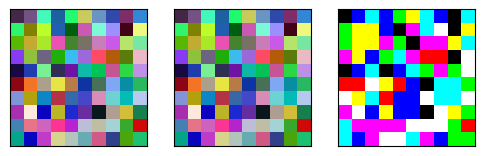

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 2))
plt.close(fig)
ax1.set_xticks([]); ax1.set_yticks([]); ax2.set_xticks([]);
ax2.set_yticks([]); ax3.set_xticks([]); ax3.set_yticks([])

np.random.seed(1337)
r = np.random.rand(10, 10, 3)

x = (r*256).astype(np.uint8)
fig_rgb(x, scale=10, ax=ax1)

x = r.astype(np.float16)
fig_rgb(x, scale=10, ax=ax2)

fig_rgb((r > 0.5), scale=10, ax=ax3)

In [ ]:
#| exporti

class RGBProxy():
    """Flexible `PIL.Image.Image` wrapper"""

    def __init__(self, x:np.ndarray):
        assert x.ndim >= 3, f"Expecting at least 3 dimensions, got shape{x.shape}={x.size}"
        self.x=x
        self.params = dict( denorm      = None,
                            cl          = True,
                            gutter_px   = 3,
                            frame_px    = 1,
                            scale       = 1,
                            view_width  = 966,
                            clip        = True,
                            ax          = None)

    def __call__(self,
                denorm      :Any    =None,
                cl          :Any    =None,
                gutter_px   :O[int] =None,
                frame_px    :O[int] =None,
                scale       :O[int] =None,
                view_width  :O[int] =None,
                clip        :Any    =None,
                ax          :O[axes.Axes]=None):

        self.params.update( { k:v for
                            k,v in locals().items()
                            if k != "self" and v is not None } )
        _ = self.fig # Trigger figure generation
        return self

    @cached_property
    def fig(self) -> figure.Figure:
        return fig_rgb(self.x, **self.params)

    def _repr_png_(self):
        from IPython.core.pylabtools import print_figure
        return print_figure(self.fig, fmt="png", pad_inches=0,
            metadata={"Software": "Matplotlib, https://matplotlib.org/"})

In [ ]:
# |export
def rgb(x           :np.ndarray,        # Array to display. [[...], C,H,W] or [[...], H,W,C]
        denorm      :Any    =None,      # Reverse per-channel normalization
        cl          :Any    =True,      # Channel-last
        gutter_px   :int    =3,         # If more than one tensor -> tile with this gutter width
        frame_px    :int    =1,         # If more than one tensor -> tile with this frame width
        scale       :int    =1,         # Stretch the image. Only integers please.
        view_width  :int    =966,       # target width of the image
        clip        :bool   =True,      # Silently clip RGB values to [0, 1]
        ax          :O[axes.Axes]=None  # Matplotlib axes
        ) -> RGBProxy:

    args = locals()
    del args["x"]

    return RGBProxy(x)(**args)

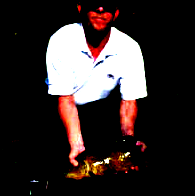

In [ ]:
# |hide
image = np.load("mysteryman.npy").transpose(1, 2, 0)
rgb(image)


In [ ]:
two_images = np.stack([image]*2)
lo(two_images)

array[2, 196, 196, 3] f32 n=230496 (0.9Mb) x∈[-2.118, 2.640] μ=-0.388 σ=1.073

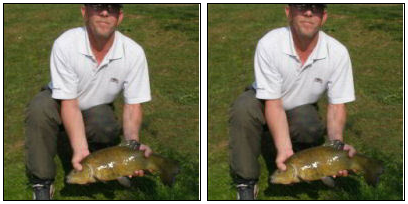

In [ ]:
in_stats = (    (0.485, 0.456, 0.406),  # Mean
                (0.229, 0.224, 0.225) ) # std
rgb(two_images, denorm=in_stats)

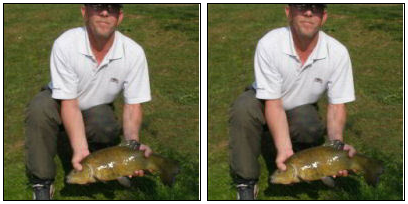

In [ ]:
# We also have presets
rgb(two_images, denorm='imagenet')

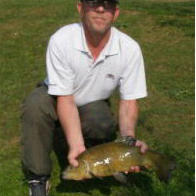

In [ ]:
tenchman_01 = image * np.array(in_stats[1]) + np.array(in_stats[0]) # This image is in the range [0 .. 1] (+/- eps)
tenchman_minus1_1 = tenchman_01 * 2 - 1 # This one is in the range [-1 .. 1] - also somewhat common
rgb(tenchman_minus1_1, denorm='symmetric') # 'symmetric' does the conversion

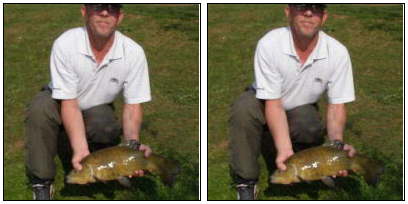

In [ ]:
rgb(image, denorm='minmax') # 'minmax' scales the full range of the inputs to [0..1].

In [ ]:
# Make 8 images with progressively higher brightness and stack them 2x2x2.
eight_images = (np.stack([image]*8) + np.linspace(-2, 2, 8)[:,None,None,None])
eight_images = (eight_images
                     *np.array(in_stats[1])
                     +np.array(in_stats[0])
                ).clip(0,1).reshape(2,2,2,196,196,3)

lo(eight_images)

array[2, 2, 2, 196, 196, 3] n=921984 (7.0Mb) x∈[0., 1.000] μ=0.382 σ=0.319

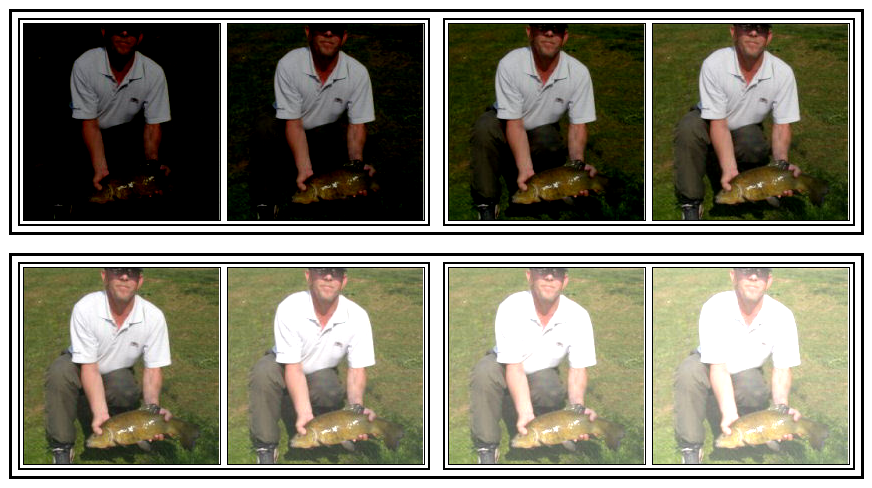

In [ ]:
rgb(eight_images)

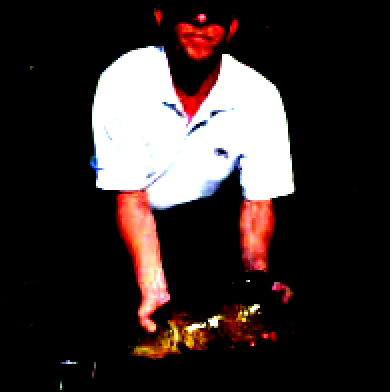

In [ ]:
# You can do channel-first too (default in PyTorch):
# Also, can scale up the image
rgb(image.transpose(-1, 0, 1), cl=False, scale=2)

In [ ]:
# |hide
try:
    rgb(np.array([]).reshape(0,0,3))
except AssertionError as e:
    test_eq(e.args[0], "Expecting non-empty input, got shape=((0, 0, 3))")
else:
    raise AssertionError("Expected AssertionError, but got nothing")

In [ ]:
# |hide
import nbdev; nbdev.nbdev_export()